# Mushroom Competition

In [237]:
#pip install sweetviz

In [238]:
#### Importing modules

In [239]:
# data wrangling
import pandas as pd
import numpy as np


#visualization
import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt
#from math import pi

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Machine Learning



# Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

# Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline #Note that make_pipeline is just a slightly more concise function than Pipeline, as it does not require you to name each step, but their behaviour is equivalent.
from sklearn import set_config


#Supervised Machine Learning


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix



#Classifier
from sklearn.ensemble import RandomForestClassifier



#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

#Metrics

from sklearn.metrics import accuracy_score


# 1. Preparing the data

In [240]:
path = '/path_to/your_files/train.csv'
data = pd.read_csv(path).set_index('Id')

In [241]:
# Exploring the data

#data.hist()
#data.describe()
#data.info()
#data

In [242]:
data['bruises'] = data['bruises'].map({True: 'True', False: 'False'})

In [243]:
#### test and train
y = data.pop('poisonous')
X = data.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state=175)

# 2. Pipeline

In [244]:
preprocessor = make_pipeline(OneHotEncoder(handle_unknown='ignore'))#, sparse_output=True))

feature_selection = SelectKBest()

full_pipeline = make_pipeline(preprocessor,
                             feature_selection,
                             RandomForestClassifier(criterion='gini'))#.set_output(transform='pandas')

In [254]:
#GridSearch

param_grid = {
     'selectkbest__k':range(35,37),
    # 'randomforestclassifier__criterion': ['gini','entropy','log_loss'], 
      'randomforestclassifier__max_depth': range(14,18),
     'randomforestclassifier__n_estimators': range(54,58),
     'randomforestclassifier__min_samples_split': range(3,6), 
      'randomforestclassifier__min_samples_leaf': range(2,3), 
 }
    

rf_search = GridSearchCV(full_pipeline,
                         param_grid=param_grid,
                        cv=5,
                         n_jobs=-1,
                        scoring='roc_auc',#'recall',#'roc_auc',
                         refit='roc_auc',#'recall', 
                        verbose=1) 

rf_search.fit(X_train,y_train)
rf_search.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 56,
 'selectkbest__k': 36}

In [255]:
y_pred = rf_search.best_estimator_.predict(X_test)


In [256]:
# Scores for the grid search results

accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
rc = cm[1][1]/(cm[1][1]+cm[1][0]) # Recall = Sensitivity = True Positive Rate = True Positive / (True Positive/False Negative)
sp = cm[0][0]/(cm[0][0]+cm[0][1]) # Specificity = True Negative Rate = True Negative / (True Negative/False Positive)

cm, accuracy, rc, sp

(array([[590,  47],
        [ 15, 648]]),
 0.9523076923076923,
 0.9773755656108597,
 0.9262166405023547)

# 3. Adjusting the decision threshold 

In [257]:
#Create an array of the class probabilites
rf_proba = rf_search.best_estimator_.predict_proba(X_test)[:, 1] # selects only the probabilities for poisonous

In [ ]:
# Adjusts the y-probablities of rf_proba to 0,1 based on a given probability threshold t
def adjusted_classes(rf_proba, t):
    return [1 if y >= t else 0 for y in y_scores]
adjusted_classes(rf_proba,0.2)

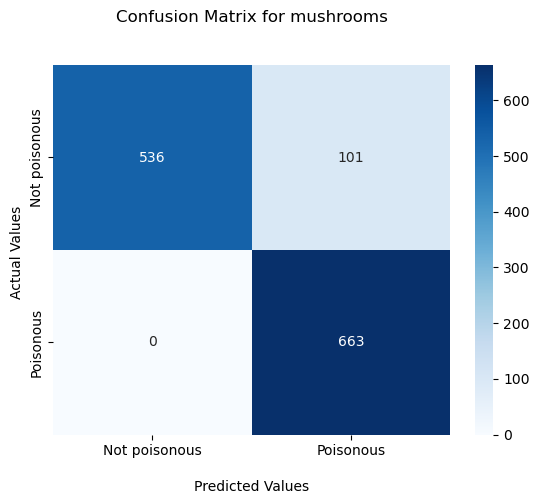

In [259]:
#Generating the precision-recall curve for the classifier
p, r, thresholds = precision_recall_curve(y_test, y_scores)

def precision_recall_threshold(p, r, thresholds, t=0.5):
       
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(rf_proba, t)
    
    cf_matrix = confusion_matrix(y_test, y_pred_adj)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Confusion Matrix for mushrooms\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Not poisonous','Poisonous'])
    ax.yaxis.set_ticklabels(['Not poisonous','Poisonous'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return y_pred_adj
    
y_pred_adj= precision_recall_threshold(p, r, thresholds, t=0.20)


In [260]:


accuracy_t = accuracy_score(y_test,y_pred_adj)
cm_t = confusion_matrix(y_test,y_pred_adj)
rc_t = cm_t[1][1]/(cm_t[1][1]+cm_t[1][0]) # Recall = Sensitivity = True Positive Rate = True Positive / (True Positive/False Negative)
sp_t = cm_t[0][0]/(cm_t[0][0]+cm_t[0][1]) # Specificity = True Negative Rate = True Negative / (True Negative/False Positive)

cm_t, accuracy_t, rc_t, sp_t

(array([[536, 101],
        [  0, 663]]),
 0.9223076923076923,
 1.0,
 0.8414442700156985)

# 4. Scores

In [261]:
scores = pd.DataFrame({'accuracy': [accuracy, accuracy_t], 
                     'recall (sensitivity)': [rc, rc_t],
                     'specificity': [sp, sp_t], 
                      }
                     , index=['radom_forest_grid','random_forest_threshold'])
scores

,accuracy,recall (sensitivity),specificity
radom_forest_grid,0.952308,0.977376,0.926217
random_forest_threshold,0.922308,1.000000,0.841444


# 5. Importing test data

In [262]:
path2 = '/path_to/your_files/test.csv'
data_t = pd.read_csv(path2)
data_t['bruises'] = data_t['bruises'].map({True: 'True', False: 'False'})

id_column = data_t.pop('Id')

# Performing the threshold adjusted prediction on the test set
y_final_pred = rf_search.best_estimator_.predict_proba(data_t) [:, 1]


# Adjusting the probabilities to 0,1
def final_adjusted_classes(y_final_pred, t):
    return [1 if y >= t else 0 for y in y_final_pred]
y_final_pred=pd.Series(final_adjusted_classes(y_final_pred,0.12))

# Saving the results

results = pd.DataFrame({'Id': id_column, 'poisonous': y_final_pred}).set_index('Id')
results.to_csv('/path_to/your_files/results.csv')